In [1]:
import xenonpy

In [2]:
# import the base module of molecular transformer
import onmt

In [3]:
from xenonpy.contrib.ismd import PoolSampler
from xenonpy.contrib.ismd import GaussianLogLikelihood
from xenonpy.contrib.ismd import ISMD
from xenonpy.descriptor import Fingerprints
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# load in-house data
data = pd.read_csv("/Users/qi/Documents/GitHub/XenonPy/xenonpy/contrib/ismd/data/STEREO_reactant_product_xlogp_tpsa.csv")[:100]

In [5]:
# take a look at the data
data.columns
data.head()

,reactant,product,XLogP,TPSA
0,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


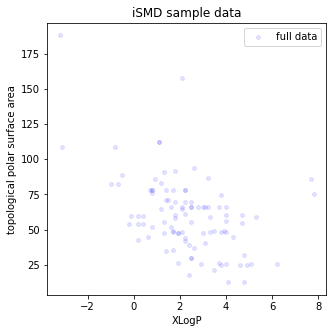

In [6]:
# check target properties: XLogP & tpsa
plt.figure(figsize=(5, 5))
plt.scatter(data['XLogP'], data['TPSA'], s=15,
            c='b', alpha=0.1, label="full data")
plt.legend(loc='upper right')
plt.title('iSMD sample data')
plt.xlabel('XLogP')
plt.ylabel('topological polar surface area')
plt.show()

   index                                       reactant  \
0     54           NN1CC(=O)NC1=O.O=C(O)C=Cc1ccc(Cl)cc1   
1     87            COC(=O)c1cc2c(cc1[N+](=O)[O-])OCCO2   
2     52              NN1CC(=O)NC1=O.O=C(Cl)C=Cc1ccccc1   
3      4      CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O   
4     96  CC(C)(C)[O-].CNc1nc(=O)c2cccnc2n1Cc1ccc(F)cc1   

                                    product  XLogP  TPSA  
0        O=C(C=Cc1ccc(Cl)cc1)NN1CC(=O)NC1=O    1.4  78.5  
1                  COC(=O)c1cc2c(cc1N)OCCO2    1.4  70.8  
2            O=C(C=Cc1ccccc1)NN1CC(=O)NC1=O    0.7  78.5  
3  CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O    3.8  74.6  
4       CN(C)c1nc(=O)c2cccnc2n1Cc1ccc(F)cc1    1.7  48.8  


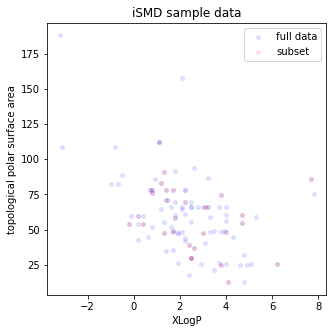

In [7]:
np.random.seed(201903) # fix the random seed

# extract a subset from the full data set
data_ss = data.sample(30).reset_index()
print(data_ss.head())

# check target properties: XLogP & tpsa
plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'], data['TPSA'],s=15,c='b',alpha = 0.1,label="full data")
plt.scatter(data_ss['XLogP'],data_ss['TPSA'],s=15,c='r',alpha = 0.1,label="subset")
plt.legend(loc='upper right')
plt.title('iSMD sample data')
plt.xlabel('XLogP')
plt.ylabel('topological polar surface area')
plt.show()

In [8]:
# build molecular transformer
from xenonpy.contrib.ismd import Reactor
ChemicalReactor = Reactor()
ChemicalReactor.BuildReactor(model_list=['/Users/qi/Documents/work/ismd_workspace/model/STEREO_mixed_augm_model_average_20.pt'], max_length=100, n_best=1)

In [9]:
# build descriptor of reactant
from xenonpy.contrib.ismd import R2Fingerprints
RDKit_FPs = R2Fingerprints(reactor=ChemicalReactor, featurizers=['ECFP', 'MACCS'], input_type='smiles')
tmp_FPs = RDKit_FPs.reactant_transform(data['product'])

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
/Users/qi/Documents/work/ONMT/onmt/translate/translator.py:501: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  finished_hyp = is_finished[i].nonzero().view(-1)


In [10]:
# descripter(fingerprint) of reactant(associated product)
print(tmp_FPs.head())

   maccs:0  maccs:1  maccs:2  maccs:3  maccs:4  maccs:5  maccs:6  maccs:7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   maccs:8  maccs:9  ...  ecfp3:2038  ecfp3:2039  ecfp3:2040  ecfp3:2041  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   ecfp3:2042  ecfp3:2043  ecfp3:2044  ecfp3:2045  ecfp3:2046  ecfp3:2047  
0   

In [11]:
# set target
prop = ['XLogP', 'TPSA']
target_range = {'XLogP': (-2, 2), 'TPSA': (0, 25)}

# import descriptor class to iQSPR and set the target of region of the properties
prd_mdls = GaussianLogLikelihood(descriptor=RDKit_FPs, targets = target_range)

In [12]:
# train forward models inside ismd
prd_mdls.fit(data['reactant'], data[prop])

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:04:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [00:04:05] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 


In [13]:
# target region can also be updated afterward
prd_mdls.update_targets(reset=True,**target_range)

In [14]:
# predicted properties of sub set
pred = prd_mdls.predict(data_ss['reactant'])
print(pred.head())

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


   XLogP: mean  XLogP: std  TPSA: mean  TPSA: std
0     1.710407    1.792676   75.307015  23.478231
1     2.250247    1.806010   59.858351  24.432166
2     1.786823    1.787461   75.236237  23.374990
3     2.990902    1.850507   63.956613  25.542176
4     1.760586    1.841255   62.046439  25.140443


In [15]:
# log likelihood of sub set
tmp_ll = prd_mdls(data['reactant'], **target_range)
print(tmp_ll.head())

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:04:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [00:04:19] Can't kekulize mol.  Unkekulized atoms: 6 13 14 15 22 23 24
RDKit ERROR: 


      XLogP      TPSA
0 -0.795522 -2.221068
1 -0.801621 -2.250610
2 -0.765253 -1.940989
3 -0.900424 -3.149892
4 -1.228735 -2.856569


In [16]:
# number of data doesn't change after reaction-forward prediction
len(tmp_ll)

100

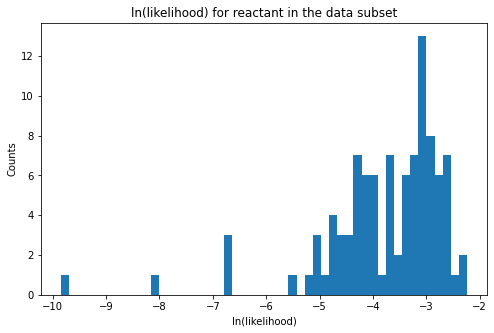

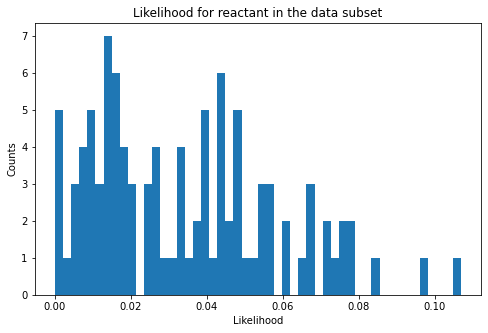

In [17]:
# plot histogram of log-likelihood values
tmp = tmp_ll.sum(axis = 1, skipna = True)

plt.figure(figsize=(8,5))
plt.hist(tmp, bins=50)
plt.title('ln(likelihood) for reactant in the data subset')
plt.xlabel('ln(likelihood)')
plt.ylabel('Counts')
plt.show()

# plot histogram of likelihood values
plt.figure(figsize=(8,5))
plt.hist(np.exp(tmp), bins=50)
plt.title('Likelihood for reactant in the data subset')
plt.xlabel('Likelihood')
plt.ylabel('Counts')
plt.show()

In [18]:
# set up initial reactants
cans = [smi for i, smi in enumerate(data['reactant'])
        if (data['XLogP'].iloc[i] > 4)]
init_samples = np.random.choice(cans, 10)
print(init_samples)

['CO.Cc1ccc2c(c1)Cc1cc(C)ccc1OC(C(=O)O)O2'
 'Clc1ccc2c(Cl)ncnc2c1.NCCCCCCCCCN'
 'CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21'
 'Clc1ccc2c(Cl)ncnc2c1.NCCCCCCCCCN'
 'CCOC(=O)CC1(O)Cc2ccccc2N(C)c2ccc(SCC)cc21'
 'NCc1cccnc1.O=C(O)C1Oc2ccc(Cl)cc2Cc2cc(Cl)ccc2O1'
 'CCO.CN1c2ccccc2CC(=O)c2cc(Br)ccc21' 'Clc1ccc2c(Cl)ncnc2c1.NCCCCCCCCCN'
 'CCOC(N)=O.Cc1ccc(N=C=O)cc1N=C=O'
 'COc1cccc(C2(CC(Cl)(Cl)Cl)CO2)c1.ClC(Cl)(Cl)CC1(c2ccc(Br)cc2)CO1']


In [19]:
# set up proposal module
reactant_pool = [line.rstrip('\n') for line in open("/Users/qi/Documents/GitHub/XenonPy/xenonpy/contrib/ismd/data/STEREO_pool.txt")]  # len(reactant_pool)=637645
reactant_pool1000 = reactant_pool[:1000]
pool_sampler = PoolSampler(reactant_pool=reactant_pool1000)

In [20]:
n_loop = 5
for i in range(n_loop):
    init_samples = pool_sampler.proposal(init_samples)
    print('Round %i' % i, init_samples)

Round 0 ['CO.COC(=O)[C@@H]1C[C@H](O)CN1', 'O=C(NN1CCCCC1)c1cccc2c1C(Cl)=Nc1ccccc1S2.NCCCCCCCCCN', 'Brc1cccc(OCc2ccccc2)n1', 'Clc1ccc2c(Cl)ncnc2c1.CC(C)(C)OC(=O)[C@@H]1C[C@H](CO)CN1C(=O)OC(C)(C)C', 'CC(=O)N(Cc1cc(C(F)(F)F)cc(C(F)(F)F)c1)C1CCCN(C(=O)OC(C)(C)C)c2ccc(C(F)(F)F)cc21', 'COc1ccc(OCC(=O)C[N+](=O)[O-])cc1OC.O=C(O)C1Oc2ccc(Cl)cc2Cc2cc(Cl)ccc2O1', 'CCO.CCCc1c(C=O)ncn1S(=O)(=O)N(C)C', 'Clc1ccc2c(Cl)ncnc2c1.CCc1cc(C(F)(C(F)(F)F)C(F)(F)F)cc(C)c1N', 'CCOC(N)=O.C=CCc1cc(OC)c(O)c(B(O)O)c1', 'CC(=O)OCC(=O)C(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1.ClC(Cl)(Cl)CC1(c2ccc(Br)cc2)CO1']
Round 1 ['CO.CCOC(=O)c1nn(C(C)C)c2ccc(F)cc12', 'O=C(NN1CCCCC1)c1cccc2c1C(Cl)=Nc1ccccc1S2.COc1cccc(Cc2nc(Cl)c(Oc3ccccc3OC)c(NS(=O)(=O)c3ccc(C(C)C)cn3)n2)c1', 'O=C1CC(c2ccccc2OCc2ccccc2)=Nc2ccc(N3CCOCC3)cc21', 'Clc1cc(Oc2ccccc2)ncn1.CC(C)(C)OC(=O)[C@@H]1C[C@H](CO)CN1C(=O)OC(C)(C)C', 'CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1', 'COc1ccc(OCC(=O)C[N+](=O)[O-])cc1OC.CC(C)(C)OC(=O)NC1(C(=O)O)CCN(C(=O)OCc2ccccc2)CC1', 'CCO.O=C1CC(

In [21]:
# set up annealing schedule
beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
print('Number of steps: %i' % len(beta))
print(beta)

Number of steps: 50
[0.01       0.02       0.03       0.04       0.05       0.06
 0.07       0.08       0.09       0.1        0.11       0.12
 0.13       0.14       0.15       0.16       0.17       0.18
 0.19       0.2        0.21       0.23111111 0.25222222 0.27333333
 0.29444444 0.31555556 0.33666667 0.35777778 0.37888889 0.4
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333
 0.8        0.86666667 0.93333333 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [22]:
# set up main procedure of ismd (SMC)
ismd = ISMD(estimator=prd_mdls, modifier=pool_sampler)

In [23]:
%%time

# main loop of ismd
ismd_samples1, ismd_loglike1, ismd_prob1, ismd_freq1 = [], [], [], []
for s, ll, p, freq in ismd(init_samples, beta, yield_lpf=True):
    ismd_samples1.append(s)
    ismd_loglike1.append(ll)
    ismd_prob1.append(p)
    ismd_freq1.append(freq)
    print(s)

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(=O)C=O.NS(=O)(=O)c1cnc2cc(Br)ccc2c1Cl'
 'CC(C)(C)OC(=O)NCCNc1c(N)c(Cl)nc2ccccc12.O=C(OCc1ccccc1)N1CCN(C[C@@H]2CCCNC2)CC1'
 'CC1(C)C(C=O)C1/C=C(\\Cl)C(F)(F)F.COc1ccc2c(c1N)C(=O)N(C)CCC2'
 'CCC(C)(C)Cc1c[nH]cn1.CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O'
 'CCO.CN(C)CCCN(c1ccccc1C(=O)c1ccccc1)c1ncccc1[N+](=O)[O-]'
 'COc1ccc2nc3cc(Cl)ccc3c(NCCNc3c4ccc(Cl)cc4nc4ccc(OC)cc34)c2c1'
 'Clc1cc(Oc2ccccc2)ncn1.Cc1cccc(-c2sc(C)nc2C(=O)N2C[C@@H]3CC(C)C[C@@H]3[C@H]2CN)c1'
 'N#Cc1nn(CCCO)cc1Br.CNCc1cccc(OCSC)c1'
 'O=C(O)CCc1cc(Cl)c(Oc2ncccc2C(=O)N2CCN(C3CC3)c3ccccc32)cc1Cl'
 'O=C1CCC(=Cc2cccc(Oc3ccc(C(F)(F)F)c(Cl)n3)c2)CC1.CC(C)c1ccccc1O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)NCCNc1c(N)c(Cl)nc2ccccc12.C[C@@H](C(=O)O)c1ccccc1'
 'CC(C)(C)c1cc(F)c2c(=O)n(-c3cccc(-n4cc(C(N)=O)c(Nc5ccc(C(C)(C)O)cc5)n4)c3C=O)ncc2c1'
 'CC(C)COc1ccc(S(C)(=O)=O)cc1C(=O)O.COc1ccc2c(c1N)C(=O)N(C)CCC2'
 'CCC(C)(C)Cc1c[nH]cn1.COC(=O)c1csc(S(=O)(=O)Oc2ccc(-c3c4ccccc4c(Br)c4sc(C)c(C)c34)cc2C2CCCC2)c1OC'
 'CCC(C)(C)Cc1c[nH]cn1.C[C@@H]1CN(c2ccc(OS(=O)(=O)C(F)(F)F)c(F)c2)C(=O)c2c(N)ncnc2O1'
 'CN1CCN(c2ccccc2CN)CC1'
 'Cc1nccs1.O=C(OCc1ccccc1)N1CCN(C[C@@H]2CCCNC2)CC1'
 'ClCc1cccnc1.CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O'
 'Clc1cc(Oc2ccccc2)ncn1.FC(F)(F)Oc1cccc(CBr)c1'
 'O=C(O)CNc1cc(C(F)(F)F)cc(C(F)(F)F)c1.O=C(OCc1ccccc1)N1CCN(C[C@@H]2CCCNC2)CC1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)COc1ccc(S(C)(=O)=O)cc1C(=O)O.C=CCOC(=O)CCCCCCCCBr'
 'CCC(C)(C)Cc1c[nH]cn1.CC1(C)CC(N)CC(C)(CN)C1'
 'CCCCn1c(-c2cc(OC)c(OC)c(OC)c2Br)nc2sc3c(O)cc(C)cc3c2c1=O'
 'Cc1c(-c2ccccc2S(C)(=O)=O)nc2cc(F)ccc2c1N1CC(C)(C)c2ccc(I)cc21'
 'Cc1cc(B2OC(C)(C)C(C)(C)O2)ccn1.CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O'
 'Cc1nccs1.COc1cc2c(Oc3cc(C)c(C)nc3-c3ccc(C)cn3)ccnc2cc1OCCCl'
 'Clc1cc(Oc2ccccc2)ncn1.BrCCCOc1cccc(-c2noc3ccsc23)c1'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1'
 'O=C(O)CNc1cc(C(F)(F)F)cc(C(F)(F)F)c1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'O=[N+]([O-])c1ccccc1CCBr.CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:04:32] SMILES Parse Error: unclosed ring for input: 'CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)CC(=O)OCCc1cccc'


['CCN(CC)CCOc1cccc(N)c1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'CNc1ccc(OC)c(N2CCN(C)CC2)c1.CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O'
 'COC(=O)[C@@H]1CC[C@@H](CO)N(C(=O)[C@@H](C)Cl)C1.C=CCOC(=O)CCCCCCCCBr'
 'COc1ccc2c(CN(c3ccc(C#N)cc3)n3ccnc3)csc2c1'
 'Cc1cc(B2OC(C)(C)C(C)(C)O2)ccn1.O=C(OCc1ccccc1)N1CCc2ccc([N+](=O)[O-])cc2CC1'
 'N#Cc1cc(-c2ccc(Cl)cc2)cnc1Cl'
 'O=C(C=CCBr)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1.C=CCOC(=O)CCCCCCCCBr'
 'O=C(O)CNc1cc(C(F)(F)F)cc(C(F)(F)F)c1.COc1ccc2c(c1)[nH]c1cc(OC)ccc12'
 'O=C(O)Cc1ccc2c(c1)OCO2'
 'O=[N+]([O-])c1ccccc1CCBr.CC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)=CCCC(C)CC(=O)O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCOC(CNC(=O)Nc2ccc(Cl)cc2)C1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'CCCC(O)CS(=O)(=O)NC(C)(C)C.O=C(OCc1ccccc1)N1CCc2ccc([N+](=O)[O-])cc2CC1'
 'CCN(CC)CCOc1cccc(N)c1.C[C@H](O)C(=O)N1CCN(Cc2cc3c(N4CCOCC4)nc(Cl)nc3s2)CC1'
 'CNc1ccc(OC)c(N2CCN(C)CC2)c1.COC(=O)c1cc(O)c2nc(C)n(C)c2c1'
 'CNc1ccc(OC)c(N2CCN(C)CC2)c1.Cc1cccc(-c2sc(C)nc2C(=O)N2C[C@@H]3CC(C)C[C@@H]3[C@H]2CN)c1'
 'ClP(c1ccccc1)c1ccccc1'
 'FC(F)(F)c1cc(Cl)nc(-c2cccnc2)n1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'O=C(C=CCBr)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1.[N-]=[N+]=NCCOc1cc2[nH]ncc2cc1N'
 'O=C1OC[C@@H]2CNCCN12.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'O=[N+]([O-])c1ccccc1CCBr.Cn1cc(Br)cn1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(=O)n1ncc2cc(-c3cc(=O)n4nc(C)nc4[nH]3)ccc21.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'CC(C)N1CCC(N)CC1'
 'CC1(C)C(C=O)C1/C=C(\\Cl)C(F)(F)F.O=C(OCc1ccccc1)N1CCc2ccc([N+](=O)[O-])cc2CC1'
 'CCCC(O)CS(=O)(=O)NC(C)(C)C.CC(=O)Nn1c(=O)[nH]c2ccccc2c1=O'
 'CCN(CC)CCOc1cccc(N)c1.N#Cc1nn(CCCO)cc1Br'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.COC(=O)c1cc(O)c2nc(C)n(C)c2c1'
 'COC(=O)c1ccc(B2OC(C)(C)C(C)(C)O2)cn1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'Cc1nc(Cl)c2nc(-c3ccccc3)cc-2[nH]1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'O=[N+]([O-])c1ccc(CCBr)cc1.O=C(OCc1ccccc1)N1CCc2ccc([N+](=O)[O-])cc2CC1'
 'O=[N+]([O-])c1ccccc1CCBr.CCOc1cc(C=O)ccc1O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc(OCc2ccccc2)n1.O=C(OCc1ccccc1)N1CCc2ccc([N+](=O)[O-])cc2CC1'
 'CC(=O)n1ncc2cc(-c3cc(=O)n4nc(C)nc4[nH]3)ccc21.ClCc1nsc(Cl)n1'
 'CCCC(O)CS(=O)(=O)NC(C)(C)C.CS(=O)(=O)OC1CCN(c2ccc([N+](=O)[O-])cc2)C1'
 'CCN(CC)CCOc1cccc(N)c1.Cc1cc(Br)cnc1O'
 'CCN(CC)CCOc1cccc(N)c1.O=C1CCN(C(=O)OCc2ccccc2)CC1'
 'CN(C)CCCN(c1ccccc1C(=O)c1ccccc1)c1ncccc1[N+](=O)[O-].COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'COC(=O)C(C)(CO)C(c1ccccc1)c1ccc2c(cnn2-c2ccc(F)cc2)c1.COc1cccc([C@@H](Oc2ccc3c(cnn3-c3ccc(F)cc3)c2)[C@H](C)N)c1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.CCCOC(CCSc1ccc(OCC(=O)OCC)c(C)c1)c1sc2cc(C(F)(F)F)ccc2c1C'
 'COC(=O)c1ccc(B2OC(C)(C)C(C)(C)O2)cn1.CC(C)(C)OC(=O)N1CCC2C(N)CCC21'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.CCOc1cc(C=O)ccc1O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc(OCc2ccccc2)n1.COC(=O)c1cc2cc(NC(=O)[C@@H]3N[C@@H](CC(C)(C)C)[C@](C#N)(c4ccc(Cl)cc4F)[C@H]3c3cccc(Cl)c3F)ccc2o1'
 'Brc1cccc(OCc2ccccc2)n1.N#Cc1ccc2ncsc2c1'
 'CC1(C)C=C(I)C(=O)C1.Cc1cc(Br)cnc1O'
 'CCN(CC)CCOc1cccc(N)c1.OC[C@H]1NCC[C@@H]1O'
 'CCOc1cc(Nc2nc(Cl)ccc2[N+](=O)[O-])n[nH]1.ClCc1nsc(Cl)n1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.CCN(C(=O)OC(C)(C)C)[C@@H]1CN(C(=O)N2CCN(S(C)(=O)=O)CC2)C[C@H]1c1ccc(Cl)c(Cl)c1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'COc1cc2c(cc1O)C(=O)CC2.CCOc1cc(C=O)ccc1O'
 'Cc1ccc(OCc2ccccc2)c2c1C(C(=O)O)CCC2.CCCOC(CCSc1ccc(OCC(=O)OCC)c(C)c1)c1sc2cc(C(F)(F)F)ccc2c1C'
 'O=Cc1ccc(Br)o1.CCOc1cc(C=O)ccc1O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc(OCc2ccccc2)n1.COC(=O)c1ccc(C)c(C(=O)Nc2ccc(N)nc2)c1'
 'Brc1cccc(OCc2ccccc2)n1.COc1nn(C)c(-c2c(F)cccc2F)c1C=O'
 'CCOc1cc(Nc2nc(Cl)ccc2[N+](=O)[O-])n[nH]1.O=C(O)Cc1ccc2oc(-c3cccnc3CO)cc2c1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.Cc1cccc(N2CCNCC2)c1'
 'COC(=O)c1sc(Br)c(Br)c1Cl.N#Cc1ccc2ncsc2c1'
 'C[C@@H](C(=O)O)c1ccccc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'C[C@H](NC(=O)CN(C)C(=O)OCc1ccccc1)C(=O)N[C@@H](C)P(=O)(O)O.Cc1cc(Br)cnc1O'
 'O=C(O)c1cccnn1.CCCOC(CCSc1ccc(OCC(=O)OCC)c(C)c1)c1sc2cc(C(F)(F)F)ccc2c1C'
 'O=C1c2sc(-c3ccc(Cl)cc3)cc2CCN1c1ccc(N2CC[C@H](O)C2)nc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc(OCc2ccccc2)n1.CN1C(=O)Cc2c(N)cccc21'
 'CC(C)(C)OC(=O)/C=C/c1ccc(C(=C2CCCCCC2)c2cccc(O)c2)cc1.Cc1cccc(N2CCNCC2)c1'
 'CC(C)(C)OC(=O)N1CCC(COS(C)(=O)=O)(C2CCCCC2)CC1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'CC(C)n1ncc2c(=O)[nH]c([C@@H]3CNC[C@H]3C)nc21.Cc1cccc(N2CCNCC2)c1'
 'CCCCc1nc(C(=O)c2ccccc2)c(C#N)[nH]1.COC(=O)c1ccc(C)c(C(=O)Nc2ccc(N)nc2)c1'
 'CCOC(=O)c1nc(-c2ccc(Cl)cc2)c(-c2ccc(Cl)cc2)nc1C=O.CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1'
 'CC[C@@H](NC(=O)OC(C)(C)C)c1ccc(Cl)c(C(=O)c2ccc(C(=O)O)nc2)c1F.CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1'
 'COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O.Cc1c(F)ccc2cnc(Cl)nc12'
 'COC(=O)C1CC(O)C(C#N)C1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'O=C(NC1N=C(c2ccccc2)c2ccccc2N(CCOCCCl)C1=O)c1cc2ccccc2[nH]1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCC(COS(C)(=O)=O)(C2CCCCC2)CC1.CCCCCCCCC1Cc2ccc(B(O)O)cc2C1'
 'CCCCc1nc(C(=O)c2ccccc2)c(C#N)[nH]1.Cc1cccc2c(C(=O)OC(C)(C)C)cccc12'
 'CCOC(=O)C(Cc1ccc(OCCNC(=O)c2ccc(-c3cccc(OC)c3)cc2)cc1)Oc1ccc(C(C)C)cc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'CCOC(=O)C1CC(Br)=NN1c1ncccc1Cl.Cc1cccc(N2CCNCC2)c1'
 'CCOC(=O)c1nc(-c2ccc(Cl)cc2)c(-c2ccc(Cl)cc2)nc1C=O.Cc1nc2ccc(N)cc2s1'
 'COC(=O)C1CC(O)C(C#N)C1.FC(F)(F)c1cc[nH]n1'
 'COCCOc1cccc(Oc2ccc(Nc3ncnc4ccn(CCNC(=O)OC(C)(C)C)c34)cc2C)c1.Cc1c(F)ccc2cnc(Cl)nc12'
 'COc1ccc2c(C)c(C)[nH]c2c1.CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1'
 'Cc1ccc(N=C=O)cc1.Cc1cccc(N2CCNCC2)c1'
 'N#C[C@@H]1CC(F)(F)CN1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCN1CCN(C(=O)c2ccc(F)c(Br)c2)CC1.Cc1nc2ccc(N)cc2s1'
 'CCOC(=O)C1CC(Br)=NN1c1ncccc1Cl.COc1ccc(NCCc2ccc(C(F)(F)F)cc2)cc1OC'
 'CCOC(=O)c1nc(-c2ccc(Cl)cc2)c(-c2ccc(Cl)cc2)nc1C=O.O=C1CNC(=O)N1CCCO'
 'CN(C)CCC(NC(=O)C1(NC(=O)OC(C)(C)C)CCN(c2ncnc3[nH]ccc23)CC1)c1ccc(Cl)cc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'COC(=O)CCCCN(Cc1ccc(OC)cc1)c1cc(C)c(Br)cc1C=O.Cc1cccc2c(C(=O)OC(C)(C)C)cccc12'
 'COc1ccc(-c2cc(-c3ccccn3)nc(-c3cccc(Br)n3)c2)cc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'Cc1ccc(N=C=O)cc1.COc1cccc(C(=O)O)c1'
 'N#C[C@@H]1CC(F)(F)CN1.COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)O)C[C@@H]3c3ccc(OC)cc3)cc21'
 'O=S([O-])c1ccccc1.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 '[N-]=[N+]=Nc1cccc(Cl)c1Cl.Cc1cccc(N2CCNCC2)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:04:59] SMILES Parse Error: extra open parentheses for input: 'CCCc1nc(C)n(C2CCOCC2)c(=O)c1Cc1ccc(-n2ccc3c(N4CCC(NC(=O)OC(C)(C)C)(C(=O)NC(CCN(C)C)c5ccc(Cl)cc5)CC4)n'


['CCN1CCN(C(=O)c2ccc(F)c(Br)c2)CC1.COC(=O)c1ccc(C2CCC2)c([N+](=O)[O-])c1'
 'CN(C)CCC(NC(=O)C1(NC(=O)OC(C)(C)C)CCN(c2ncnc3[nH]ccc23)CC1)c1ccc(Cl)cc1.CCCc1nc(C)n(C2CCOCC2)c(=O)c1Cc1ccc(Br)cc1'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].Cc1cccc2c(C(=O)OC(C)(C)C)cccc12'
 'COCCCOc1cc(C(=O)N(C[C@@H]2CN(C(=O)OC(C)(C)C)C[C@H]2CN=[N+]=[N-])C(C)C)ccc1OC.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'C[C@H]1CN(c2ncc(B3OC(C)(C)C(C)(C)O3)cc2C=O)C[C@@H](C)O1.Cc1nc2ccc(N)cc2s1'
 'C[Si](C)(C)CC(NC(=O)c1cccc(I)c1)C(=O)NC1(C#N)CC1.COc1cccc(C(=O)O)c1'
 'Cc1nn(-c2c(Cl)cc(C(F)(F)F)cc2Cl)cc1C#C[Si](C)(C)C.COCCn1cc(C(=O)N2CCC(c3cc(CNC(=O)C(F)(F)F)ccc3F)CC2)c2c(N)cccc21'
 'FCCCCBr.Cc1cccc(N2CCNCC2)c1'
 'O=C(Nc1nc(-c2ccco2)c(C(=O)c2ccccc2)s1)c1ccc(Cl)nc1.COc1cccc(C(=O)O)c1'
 'O=C1OC(CCO)C(O)=C1OCc1ccccc1.O=C1CNC(=O)N1CCCO']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCN1CCN(C(=O)c2ccc(F)c(Br)c2)CC1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'CCc1c(C2(O)CCNCC2)sc2ccccc12.CCCc1nc(C)n(C2CCOCC2)c(=O)c1Cc1ccc(Br)cc1'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].Oc1ccc2c(c1)CCCC(c1ccccc1)=C2c1ccc(OCCCCCSCCCC(F)(F)F)cc1'
 'COCCCOc1cc(C(=O)N(C[C@@H]2CN(C(=O)OC(C)(C)C)C[C@H]2CN=[N+]=[N-])C(C)C)ccc1OC.CCOC(=O)C(C)(CCCCCBr)c1ccccc1'
 'C[C@H]1CN(c2ncc(B3OC(C)(C)C(C)(C)O3)cc2C=O)C[C@@H](C)O1.CC(C)(C)OC(=O)N1CCN(CC(c2cccc(-c3ccccc3F)c2)C2(O)CCCCC2)CC1'
 'Cc1cnc2ccc(Cl)nn12.COc1cccc(C(=O)O)c1'
 'FCCCCBr.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'FCCCCBr.CCCOc1ccc(NC(C)=O)cc1NC(C)=O'
 'O=C(Nc1nc(-c2ccco2)c(C(=O)c2ccccc2)s1)c1ccc(Cl)nc1.CCCC[Sn](CCCC)(CCCC)c1cc2c(cn1)cnn2-c1cccc(N2CCCN(C(=O)OC(C)(C)C)CC2)n1'
 'O=C(Nc1nc(-c2ccco2)c(C(=O)c2ccccc2)s1)c1ccc(Cl)nc1.Cc1cc(N2CCC(CN3CCCC3C)C2)ccc1N']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:05:06] Can't kekulize mol.  Unkekulized atoms: 1 2 28 29 30 31 33
RDKit ERROR: 


['CCc1c(C2(O)CCNCC2)sc2ccccc12.C[C@H](c1ccccc1F)N(Cc1ccc(C(=O)N[C@H]2C[C@@H](C(=O)N[C@@H]3CCCc4ccccc43)N(C(=O)OC(C)(C)C)C2)cc1)C(=O)[C@@H]1Cc2ccccc2CN1'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].CC(C)Oc1ccc(C(=O)O)cc1'
 'COc1ccc(C(=O)c2c(CO[N+](=O)[O-])n(C(C)=O)c(=O)n2C(C)=O)cc1.COc1cccc(C(=O)O)c1'
 'COc1ccc2c(c1)C(=C(C)c1ccc[nH]1)C(=O)N2.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'CS(=O)(=O)Nc1c(F)cc(CN)cc1C(F)(F)F.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'Cc1cnc2ccc(Cl)nn12.ClC/C=C/c1ccc(C#Cc2ccc(-c3ccc(Cl)cc3)cn2)cc1'
 'FCCCCBr.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1'
 'NCCN1CCN(Cc2ccccc2)CC1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'O=C(O)c1cc(F)c(F)cc1Br.COc1cccc(C(=O)O)c1'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.CCCOc1ccc(NC(C)=O)cc1NC(C)=O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC1(C)C=C(I)C(=O)C1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'CC1C(=O)CCC(C)(C)C1=O.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1'
 'CCCCc1nnc2ccccc2c1Cl.COc1cccc(C(=O)O)c1'
 'CCOC(=O)C(C)(Cc1ccc(OCCC2CN(Cc3cccc(C(F)(F)F)c3)C(=O)N2C)cc1)Oc1ccccc1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].CN1CCC2(CC1)COc1cc3c(cc12)NCC3'
 'Cc1cc([C@@H]2C[C@H]2N)ccc1NC(=O)c1ccccc1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'Cc1ccc(CCN(C(=O)C(OS(C)(=O)=O)c2ccccc2)c2ccc(C)c(C)c2)cc1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'NCCN1CCN(Cc2ccccc2)CC1.NNc1cc2c(nn1)CCN(C(=O)c1ccc(Cl)cc1)C2'
 'O=C(O)c1cc2cc(Cl)ncc2[nH]1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.CC(C)(C)c1cc(N)n(-c2cn(CCOC3CCCCO3)cn2)n1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['COC(=O)CC(Cc1ccc(OCc2ccccc2)cc1)c1nc(C(F)(F)F)cs1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].CON(C)C(=O)c1cc(Cn2cncn2)cc(C(=O)c2ccccc2)c1'
 'COc1ccc2nc(CCl)cn2c1.CSc1ncc2cc(-c3ccc(Br)cc3Cl)c(=O)n(C[C@H]3CN(C(=O)OC(C)(C)C)CCO3)c2n1'
 'Cc1cc([C@@H]2C[C@H]2N)ccc1NC(=O)c1ccccc1.COc1ccc(-c2c(C(=O)O)[nH]c3cc(OC)c(OC)cc23)cc1OC'
 'Cc1cc([C@@H]2C[C@H]2N)ccc1NC(=O)c1ccccc1.Cc1ccc(OCc2ccccc2)c2c1C(C(=O)O)CCC2'
 'O=C(O)c1cc2cc(Cl)ncc2[nH]1.CC(C)(C)OC(=O)CN1C(=O)[C@@H](N[C@@H](CCC2CCCCC2)C(=O)O)COc2ccccc21'
 'O=C(O)c1cc2cc(Cl)ncc2[nH]1.CCOC(=O)COc1cc(C2CCCN(C(=O)c3sc(-c4ccc(C(F)(F)F)cc4)nc3C)C2)ccc1C'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.COC(=O)C(N)C1CCCN(C(=O)OC(C)(C)C)C1'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.O=[N+]([O-])c1ccc(Nc2cncnc2)cc1'
 'OCC1=CN2CCC1CC2.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCN(C(=O)Cc1ccc(F)cc1)C1CCNCC1.CCOC(=O)COc1cc(C2CCCN(C(=O)c3sc(-c4ccc(C(F)(F)F)cc4)nc3C)C2)ccc1C'
 'CNCc1cccc2c1C(=O)N(C1CCC(=O)NC1=O)C2=O.O=[N+]([O-])c1ccc(Nc2cncnc2)cc1'
 'COC(=O)CC(Cc1ccc(OCc2ccccc2)cc1)c1nc(C(F)(F)F)cs1.CN(CC1CCCN1C(=O)OC(C)(C)C)S(C)(=O)=O'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].O=C(Nc1ccc2c(c1)c(-c1nc3cc(N4CCOCC4)ccc3[nH]1)nn2C1CCCCO1)C1CCC(F)(F)CC1'
 'Fc1ccc(Br)c(F)c1.COc1ccc(-c2c(C(=O)O)[nH]c3cc(OC)c(OC)cc23)cc1OC'
 'Nc1ccc(CCN2CCCC2)cc1.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1'
 'Nc1nc(Cl)c2c(n1)-c1ccccc1CCC2.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.CC1(C)CNCCN1S(C)(=O)=O'
 'O=S(=O)(Cl)c1cc(C(F)(F)F)ccc1F.Cc1c(-c2ccccc2S(C)(=O)=O)nc2cc(F)ccc2c1N1CC(C)(C)c2ccc(I)cc21'
 'OCC1=CN2CCC1CC2.Cc1ccc(I)cc1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)C(c1ccc(OCc2ccccn2)cc1)c1ccc(C(=O)NC2CCNCC2)cc1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CCN(C(=O)Cc1ccc(F)cc1)C1CCNCC1.FC(F)(F)CCCCCBr'
 'CCN(C(=O)Cc1ccc(F)cc1)C1CCNCC1.O=C[C@@]12CCCN1[C@@H](C(Cl)(Cl)Cl)OC2=O'
 'CCOC(OCC)(OCC)c1ccc2c(-c3ccnc(NC4CCCC4)n3)c(-c3ccc(F)cc3)nn2c1.Cc1ccc(I)cc1'
 'CCn1c(C)c(C(=O)NC)c2ccc(O)cc21.COc1ccc(-c2c(C(=O)O)[nH]c3cc(OC)c(OC)cc23)cc1OC'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].O=C(O)Cc1ccc2oc(-c3cccnc3CO)cc2c1'
 'COC(=O)c1ccc(C)c(C(=O)Nc2ccc(N)nc2)c1.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1'
 'ClP(c1ccccc1)c1ccccc1.O=C1C[C@@]2(c3ccccc3)[C@H](OCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)CC[C@@H]1N2Cc1ccccc1'
 'Fc1ccc(Br)c(F)c1.COCCCOc1cc(C[C@@H](C[C@H]2[C@H](C[C@H](C(=O)NCC(C)(C)C(N)=O)C(C)C)OCN2C(=O)OCCl)C(C)C)ccc1OC'
 'O=C(O)c1ccc([N+](=O)[O-])cc1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCC2C(N)CCC21.FC(F)(F)CCCCCBr'
 'CC(C)(C)OC(=O)[C@@H]1C[C@H](CO)CN1C(=O)OC(C)(C)C.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CC(O)c1ccc(F)cc1.O=C(O)Cc1ccc2oc(-c3cccnc3CO)cc2c1'
 'CCN(C(=O)Cc1ccc(F)cc1)C1CCNCC1.CCc1ccc(F)c(Br)c1'
 'CCN(C(=O)Cc1ccc(F)cc1)C1CCNCC1.CNC1=NCC(c2ccc([N+](=O)[O-])cc2)c2cc(Cl)ccc21'
 'CCNc1ccc(C(C)=O)cc1N=C1SC(=C2Sc3ccccc3N2C)C(=O)N1Cc1ccccc1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CCOC(OCC)(OCC)c1ccc2c(-c3ccnc(NC4CCCC4)n3)c(-c3ccc(F)cc3)nn2c1.FC(F)(F)CCCCCBr'
 'COC(=O)CCC(C)(c1ccc2cc(O[C@H]3CC[C@H](C(F)(F)F)CC3)ccc2c1)[N+](=O)[O-].Clc1ccc2cc(CBr)ccc2c1'
 'Fc1ccc(Br)c(F)c1.COC(=O)CCCCN(Cc1ccc(OC)cc1)c1cc(C)c(Br)cc1C=O'
 'O=C(c1ccccc1C(F)(F)F)N1CCNCC1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['C#CCCN1C(=O)c2ccccc2C1=O.O=C(O)Cc1ccc2oc(-c3cccnc3CO)cc2c1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CC1(C)CC2CCC(C(=O)O)CN2C1=O.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'CCOC(OCC)(OCC)c1ccc2c(-c3ccnc(NC4CCCC4)n3)c(-c3ccc(F)cc3)nn2c1.CC(C)(C)[C@H](N)C(=O)O'
 'CCOC(OCC)(OCC)c1ccc2c(-c3ccnc(NC4CCCC4)n3)c(-c3ccc(F)cc3)nn2c1.CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC'
 'NCCC[C@@H](O)C(=O)O.C=CCOc1c(Cl)cccc1C(=O)NC1(C(=O)OCC)Cc2ccccc2C1'
 'O=C(O)Cc1ccc2oc(-c3cccnc3CO)cc2c1.CNC1=NCC(c2ccc([N+](=O)[O-])cc2)c2cc(Cl)ccc21'
 'O=C(OC1CCN(Cc2ccc([N+](=O)[O-])cc2)CC1)c1ccccc1.FC(F)(F)CCCCCBr'
 'O=C(c1ccccc1C(F)(F)F)N1CCNCC1.CC1(C)C(C=O)C1/C=C(\\Cl)C(F)(F)F']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc2ccc(-n3cnc4cc5c(cc43)OCCO5)nc12.CC1(C)C(C=O)C1/C=C(\\Cl)C(F)(F)F'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.CC(C)(C)OC(=O)N[C@@H](CC(=O)O)C(=O)OCc1ccccc1'
 'CC1(C)CC2CCC(C(=O)O)CN2C1=O.COc1ccc2nccc(N3CCN(CCN)CC3)c2c1'
 'CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1.COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)O)C[C@@H]3c3ccc(OC)cc3)cc21'
 'CN(C(=O)OCc1ccccc1)[C@@H]1CCNC1.CNC1=NCC(c2ccc([N+](=O)[O-])cc2)c2cc(Cl)ccc21'
 'N[C@@H]1C[C@H]1c1ccccc1.CC1(C)C(C=O)C1/C=C(\\Cl)C(F)(F)F'
 'O=C(OC1CCN(Cc2ccc([N+](=O)[O-])cc2)CC1)c1ccccc1.C=CCc1cc(N)ccc1OC'
 'O=C(OC1CCN(Cc2ccc([N+](=O)[O-])cc2)CC1)c1ccccc1.O=C(Cl)N1CC(Oc2ccccc2Cl)C1'
 'O=Cc1ccc(C(F)(F)F)nc1.FC(F)(F)CCCCCBr']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:05:35] Can't kekulize mol.  Unkekulized atoms: 34 35 36 37 38 39 40
RDKit ERROR: 


['Brc1cccc2ccc(-n3cnc4cc5c(cc43)OCCO5)nc12.C[Si](C)(C)CC(NC(=O)c1cccc(I)c1)C(=O)NC1(C#N)CC1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.COC(=O)C1CN(Cc2ccc(C(C)=CC(=O)c3cc(OC)c(OC)c(OC)c3)cc2)C1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.OC1CCCC(Nc2ccc3ncc(-c4cc(F)nc(Cl)c4)n3c2)C1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O'
 'CC1(C)CC2CCC(C(=O)O)CN2C1=O.COC(=O)CCC/C=C\\C[C@H]1[C@@H](O)C[C@@H](OC2CCCCO2)[C@@H]1CO[Si](C)(C)C(C)(C)C'
 'CC1(C)CC2CCC(C(=O)O)CN2C1=O.COc1cc(C(C)(C)C)c(O)c(C(=O)Nc2ccc(S(=O)(=O)C(F)(F)F)cc2Cl)c1C'
 'CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1.CCCN(CCC)CCCCN'
 'CCOC(=O)c1cc2c3ccccc3[nH]c(=O)n2n1.CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC'
 'Cc1ccc(C(=O)O)c(Cl)n1.CC(C)(C)OC(=O)N[C@@H](CC(=O)O)C(=O)OCc1ccccc1'
 'N[C@@H]1C[C@H]1c1ccccc1.OCc1cccc2c(O)cccc12']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc2ccc(-n3cnc4cc5c(cc43)OCCO5)nc12.O=C(O)c1cc(F)c(F)cc1Br'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CCOC(=O)C(Br)c1ccccc1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.N#Cc1ccc([N+](=O)[O-])c(F)c1'
 'CC(C)(C)SC1CC(=O)c2ccccc21.CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC'
 'CC1(C)CC2CCC(C(=O)O)CN2C1=O.CCc1c(C2(O)CCNCC2)sc2ccccc12'
 'CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1.CC(C)(C)SC1CC(=O)c2ccccc21'
 'CC1CCN(c2nc(C(F)(F)F)ccc2CN)CC1.O=C(O)Cc1ccc2c(c1)OCO2'
 'CCOC(=O)COc1cc(C2CCCN(C(=O)c3sc(-c4ccc(C(F)(F)F)cc4)nc3C)C2)ccc1C.COC(=O)C(C)N1CCCCCC(N=[N+]=[N-])C1=O'
 'Nc1ccc(C(F)(F)F)cc1C(=O)O.CCCN(CCC)CCCCN'
 '[N-]=[N+]=NCCOc1cc2[nH]ncc2cc1N.C[Si](C)(C)CC(NC(=O)c1cccc(I)c1)C(=O)NC1(C#N)CC1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['Brc1cccc2ccc(-n3cnc4cc5c(cc43)OCCO5)nc12.COc1cc2c(Cl)ncnc2cc1O'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.COc1ccccc1OC(c1ccccc1)C(O)C[N+](=O)[O-]'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.Nc1coc2ccccc2c1=S'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.CCNC(=O)Nc1cc(-c2nc(-c3ccccc3)cs2)c(Br)cn1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.CCc1nc2ccccc2n1-c1nc(N2CCOCC2)c2nc(C=O)n(C)c2n1'
 'COC(=O)[C@@H](N)C(C)C.CCc1c(C2(O)CCNCC2)sc2ccccc12'
 'NN1CCNC(=O)C1=O.CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC'
 'Nc1ccc(C(F)(F)F)cc1C(=O)O.CCOC(=O)c1cnn(-c2cccc(-c3cc(C)ccc3OCc3ccc(C4=CCN(C(=O)OC(C)(C)C)CC4)cc3)n2)c1C(F)(F)F'
 'Nc1ccc(C(F)(F)F)cc1C(=O)O.CCc1ccc(F)c(Br)c1'
 '[N-]=[N+]=NCCOc1cc2[nH]ncc2cc1N.COC(=O)c1cc(NS(C)(=O)=O)ccc1/C=C/c1cc(-c2cccnc2OCc2ccccc2)cc(C(C)(C)C)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['C#Cc1cc(C)cc(Nc2nccc(C(F)F)n2)c1.COc1ccccc1OC(c1ccccc1)C(O)C[N+](=O)[O-]'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.N#Cc1ccc(CN)s1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.N#Cc1cccnc1Br'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.C=Cc1cccc([N+](=O)[O-])c1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.COC(=O)[C@H](C)O'
 'COC(=O)[C@@H](N)C(C)C.CC(=O)N1CCC(=O)NCc2cc(N)ccc21'
 'CON(C)C(=O)c1cc(Cn2cncn2)cc(C(=O)c2ccccc2)c1.CCc1nc2ccccc2n1-c1nc(N2CCOCC2)c2nc(C=O)n(C)c2n1'
 'Cc1cc(OCc2c(F)cccc2F)c2nc(C)c(C(=O)O)n2c1.CCOC(=O)c1cnn(-c2cccc(-c3cc(C)ccc3OCc3ccc(C4=CCN(C(=O)OC(C)(C)C)CC4)cc3)n2)c1C(F)(F)F'
 'Fc1cc(Br)ccc1Br.CCc1c(C2(O)CCNCC2)sc2ccccc12'
 'Nc1ccc(C(F)(F)F)cc1C(=O)O.CCN(CC)C(=O)c1ccc(C(c2cccc3cccnc23)N2CCNCC2)cc1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['C=CCc1cc(OC)c(O)c(B(O)O)c1.CC(=O)N1CCC(=O)NCc2cc(N)ccc21'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CCOC(=O)N=NC(=O)OCC'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.Cn1cc(-c2ccc(=O)n(Cc3cccc(-c4ncc(O)cn4)c3)n2)cn1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.O=C(OCc1ccccc1)c1ccc(OC2CCC3(CC2)OCCO3)cc1'
 'CON(C)C(=O)c1cc(Cn2cncn2)cc(C(=O)c2ccccc2)c1.CC1CC(c2cccc(Br)c2)=CCN1'
 'Cc1cc(OCc2c(F)cccc2F)c2nc(C)c(C(=O)O)n2c1.O[C@H]1CNCC[C@@]1(O)Cc1ccccc1'
 'Cn1ncc(N)n1.N#Cc1ccc(CN)s1' 'Fc1cc(Br)ccc1Br.COC(=O)c1c(C)nc(Cl)nc1OC'
 'Fc1cc(Br)ccc1Br.O=C(O)/C=C/C(O)c1ccc(-c2ccc(F)c(F)c2)cc1'
 'O=C(O)C=Cc1cc(Cl)cc(Cl)c1.CCc1c(C2(O)CCNCC2)sc2ccccc12']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CC(C)(NCCCn1ccnc1)c1ccc(Cl)cc1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.COC(=O)CC(=O)N1C[C@H](Cc2ccc(Cl)c(Cl)c2)C[C@H]1CCNC(=O)CSc1ncc(-c2ccc(OC)c(OC)c2)cn1'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'CCOC(=O)c1c(CCl)nc2cc(OC)c(OC)cc2c1-c1ccc(OC)c(OC)c1.CCOC(=O)N=NC(=O)OCC'
 'Cc1nc2c3c(c(C(=O)N(C)C)cn2c1C=O)CCC(c1ccccc1)C3.N#Cc1ccc(CN)s1'
 'Cn1ncc(N)n1.Cc1cccc(N2c3ccccc3CN(CCCCl)S2(=O)=O)c1'
 'Fc1cc(Br)ccc1Br.NCC1CN(C(c2ccccc2)c2ccccc2)C1'
 'NC(=S)c1ccc(Cl)c(Cl)c1.O=C(O)/C=C/C(O)c1ccc(-c2ccc(F)c(F)c2)cc1'
 'O=C(O)C=Cc1cc(Cl)cc(Cl)c1.NCC(O)CO'
 'OC1CCCC(Nc2ccc3ncc(-c4cc(F)nc(Cl)c4)n3c2)C1.CCc1c(C2(O)CCNCC2)sc2ccccc12']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CC(C)(C)CCCC(=O)CCCCCCCCCCBr'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CSCCC(CO)NC(=O)OC(C)(C)C'
 'CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.O=C(c1ccccc1C(F)(F)F)N1CCNCC1'
 'CCOC(=O)c1nc(-c2cccc(C#C[C@]3(O)CCN(C)C3=O)c2)nc2ccc(OC)cc12.NCC(O)CO'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.CCOC(=O)N=NC(=O)OCC'
 'COc1c(NC(=O)OCC(Cl)(Cl)Cl)cc(C(C)(C)C)cc1C(O)C(F)(F)F.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'Cc1cc(C(=O)NCCc2ccc(Cl)cc2)ccc1Br.CCOC(=O)N=NC(=O)OCC'
 'Nc1nc(-n2cc(C(=O)O)c(=O)c3cc(F)c(F)c(Cl)c32)c(Cl)cc1F.CC(C)(NCCCn1ccnc1)c1ccc(Cl)cc1'
 'O=C(O)c1ccc(Cl)c(Cl)c1.N#Cc1ccc(CN)s1'
 'OC1(C#Cc2cccc(Cl)c2)CCNCC1.NCC1CN(C(c2ccccc2)c2ccccc2)C1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCOC(=O)C1Cc2ccccc2CN1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'CCOC(=O)N1CCC(N)CC1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.Cc1nc(Oc2ccccc2)c([N+](=O)[O-])c(NCCCCCCl)c1C'
 'CN(C)C(=O)c1ccccc1[N+](=O)[O-].CC(C)(C)CCCC(=O)CCCCCCCCCCBr'
 'COc1ccc(-c2nc(OC)oc2-c2ccc(OCCOS(C)(=O)=O)cc2)cc1.N#Cc1ccc(CN)s1'
 'Cc1c(C#C[Si](C)(C)C)cc(C(C)(C)C)c(OC(C)C)c1C=O.NCC(O)CO'
 'Cc1cc(O)ccc1NC(=O)OC(C)(C)C.CC(C)(C)CCCC(=O)CCCCCCCCCCBr'
 'O=C(O)c1ccc(Cl)c(Cl)c1.CC(C)(C)c1cc(F)c2c(=O)n(-c3cccc(-n4cc(C(N)=O)c(Nc5ccc(C(C)(C)O)cc5)n4)c3C=O)ncc2c1'
 'O=C(O)c1ccc(I)cc1C(F)(F)F.Nc1ccc2c(=O)[nH]c3ncccc3c2c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)Nc1ncc(C=O)s1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'CCOC(=O)N1CCC(N)CC1.CCOC(=O)C(C)(C)Oc1ccc2c(c1)C(=CCCN1CCC(O)(c3ccc(Cl)cc3)C(C)(C)C1)c1cccnc1CO2'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.COC(=O)c1csc(Br)c1NS(=O)(=O)c1ccc(OC)cc1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.[BH3-]C#N'
 'CN(C)C(=O)c1ccccc1[N+](=O)[O-].O=C(O)c1cc(Cl)c(OC2CCCC2)c(Cl)c1'
 'COC(=O)[C@H](Cc1ccccc1)Nc1ncnc(Cl)c1C=O.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'COC(=O)c1cc(N2CCOC[C@@H]2C)nc(Cl)n1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'COC(=O)c1ccc(-c2ccccc2NC(=O)c2cccc(-c3ccc(OC)cc3OC)c2)s1.Nc1ccc2c(=O)[nH]c3ncccc3c2c1'
 'COc1ccccc1C(=O)NCC1(c2ccccc2)CCNCC1.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'Cn1cc(-c2cc(N)ccc2OC2CCOC2)c2cc[nH]c2c1=O.N#Cc1ccc(CN)s1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:05] SMILES Parse Error: extra open parentheses for input: 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@@H](N)CC(=O)OC(C)(C)C)C(C'


['CC(C)(C)OC(=O)/C=C/c1ccc(C(=C2CCCCCC2)c2cccc(O)c2)cc1.COC(=O)c1csc(Br)c1NS(=O)(=O)c1ccc(OC)cc1'
 'CC(C)CCI.COC(=O)c1csc(Br)c1NS(=O)(=O)c1ccc(OC)cc1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.COc1ccc(-c2nn3c(Cl)cccc3c2-c2ccnc(NC3CCCC3)n2)cc1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C'
 'COC(=O)[C@H](C)O.CCOC(=O)C(C)(C)Oc1ccc2c(c1)C(=CCCN1CCC(O)(c3ccc(Cl)cc3)C(C)(C)C1)c1cccnc1CO2'
 'COc1cc(N2CCN(C)CC2)ccc1Nc1nnc(C(=O)c2cccc(N)c2)s1.[BH3-]C#N'
 'COc1ccccc1C(=O)NCC1(c2ccccc2)CCNCC1.CC(=O)Cn1c(COCc2ccccc2)nc(C(C)C)c1Sc1cc(Cl)cc(Cl)c1'
 'COc1ccccc1C(=O)NCC1(c2ccccc2)CCNCC1.CCn1c(-c2ccc(C)cc2)cc2cc([N+](=O)[O-])cnc21'
 'C[C@H](CO[Si](C)(C)C(C)(C)C)OC[C@H](Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)Nc1ccc(F)cn1.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'Cn1cc(-c2cc(N)ccc2OC2CCOC2)c2cc[nH]c2c1=O.CCOC(=O)c1cc([N+](=O)[O-])ccc1Oc1ccc(F)c(F)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)CCI.C1CN2CCC(CC2)N1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.Brc1ccccn1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.O=Cc1ccc(O)c(Cl)c1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.OCC1=CN2CCC1CC2'
 'COC(=O)c1c(C)nc(Cl)nc1OC.COC(=O)c1csc(Br)c1NS(=O)(=O)c1ccc(OC)cc1'
 'COC(=O)c1cc2cc(OC)c(OC)cc2c(-c2ccnc(Br)c2)c1C(=O)OC.Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C'
 'COc1cc(N2CCN(C)CC2)ccc1Nc1nnc(C(=O)c2cccc(N)c2)s1.COC(=O)c1ccc2c(c1)c1c(n2C)CCNC1'
 'COc1ccc2nccc(N3CCN(CCN)CC3)c2c1.CCOC(=O)c1cc([N+](=O)[O-])ccc1Oc1ccc(F)c(F)c1'
 'Clc1cc(Oc2ccccc2)ncn1.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'O=C(O)c1cc2cc(Cl)ncc2[nH]1.CCn1c(-c2ccc(C)cc2)cc2cc([N+](=O)[O-])cnc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)CCI.CCS(=O)(=O)CCC(=O)NNC(=O)N1Cc2ccccc2Oc2ccc(N)cc21'
 'CC(C)CCI.CN(C)c1cccc2c(S(=O)(=O)NCCCOCCOCCCN)cccc12'
 'CC(C)CCI.OC[C@H]1NCC[C@@H]1O'
 'CCCC[C@H](NC(=O)OC(C)(C)C)C(O)c1cc1=O.COC(=O)c1ccc2c(c1)c1c(n2C)CCNC1'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.COc1cc(Cl)ccc1C#CCCO'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.COc1ccc(S(=O)(=O)Nc2ccccc2)c2c1C[C@@H](N)CC2'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.Cc1cnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2'
 'COC(=O)c1c(C)nc(Cl)nc1OC.C[C@@H]1CN(c2ccc(OS(=O)(=O)C(F)(F)F)c(F)c2)C(=O)c2c(N)ncnc2O1'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.C1CN2CCC(CC2)N1'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:15] Can't kekulize mol.  Unkekulized atoms: 15 16 19 28 29
RDKit ERROR: 
RDKit ERROR: [00:06:15] SMILES Parse Error: syntax error while parsing: CSc1ccc(NC2CCN(C(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](Cc3ccccc3C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)[C@H](CC(C)C)NC(
RDKit ERROR: [00:06:15] SMILES Parse Error: Failed parsing SMILES 'CSc1ccc(NC2CCN(C(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](Cc3ccccc3C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)[C@H](CC(C)C)NC(' for input: 'CSc1ccc(NC2CCN(C(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](Cc3ccccc3C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)[C@H](CC(C)C)NC('


['CC(C)CCI.CC(C)(C)[Si](C)(C)Oc1ccc(NC(=O)CCl)cc1'
 'CCCC[C@H](NC(=O)OC(C)(C)C)C(O)c1cc1=O.NN1CCNC(=O)C1=O'
 'CCOc1cc(N2CCN(CCS(C)(=O)=O)CC2)c(C)cc1N.COC(=O)COCCCCN1C(=O)CC[C@H]1CCC(=O)Cc1cccc(Cl)c1'
 'CN1C(=O)Cc2c(N)cccc21.COC(=O)c1ccc2c(c1)c1c(n2C)CCNC1'
 'Cc1cc(B2OC(C)(C)C(C)(C)O2)ccn1.COc1cc(Cl)ccc1C#CCCO'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.CC(C)(C)OC(=O)N1CCC(Cn2cc(C(N)=O)cn2)CC1'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.Fc1cc(Br)ccc1Br'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.CS(=O)(=O)OCCC#Cc1ccc2c(-c3ccc(Br)cc3)nsc2c1'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.O=C1c2ccc(F)c(Br)c2OCCN1Cc1ccccc1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCC(Cl)=Nc1c(C)cc(C(=O)C(C)C)nc1Cl.CC(C)(C)OC(=O)N1CCC(Cn2cc(C(N)=O)cn2)CC1'
 'CN1C(=O)Cc2c(N)cccc21.CC1(C)COC(c2ccccc2-c2ccc(C(=O)O)cc2)=N1'
 'COC(=O)CC(=O)N1C[C@H](Cc2ccc(Cl)c(Cl)c2)C[C@H]1CCNC(=O)CSc1ncc(-c2ccc(OC)c(OC)c2)cn1.Fc1cc(Br)ccc1Br'
 'COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)O)C[C@@H]3c3ccc(OC)cc3)cc21.CSc1ccc(NC2CCNCC2)cc1C(F)(F)F'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.Fc1ccc(C(Cl)Cn2ccnc2)cc1'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.C=C[C@@H]1C[C@]1(N)C(=O)NS(=O)(=O)c1ccccc1NCCCCN(C)CCCC(=O)OC'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.CC(C)(C)OC(=O)N1CCN(CC(c2cccc(C#N)c2)C2(O)CCCCC2)CC1'
 'O=C(Cl)N1CC(Oc2ccccc2Cl)C1.CCCCCC1C(CC=O)CCC12OCCO2'
 'O=[N+]([O-])c1cc(Cl)c(Cl)nc1Cl.COC(=O)COCCCCN1C(=O)CC[C@H]1CCC(=O)Cc1cccc(Cl)c1'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.CN(C)C(=O)c1ccccc1[N+](=O)[O-]']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:24] SMILES Parse Error: extra open parentheses for input: 'COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)Nc4ccc(-c5cc(CS(C)(=O)=O)nc6c5cnn6C)cc4)C[C@@H]3c3ccc(OC)cc'


['CC(=O)Oc1ccc(N=c2scc(-c3ccc(Cl)c(S(=O)(=O)N(C)C)c3)n2C)cc1.CN(C)C(=O)c1ccccc1[N+](=O)[O-]'
 'CC(=O)c1cnc2ccc(Cl)nc2c1NC1CCC(CN2CC[C@@H](F)C2)CC1.CC(C)(C)OC(=O)N1CCN(CC(c2cccc(C#N)c2)C2(O)CCCCC2)CC1'
 'CC(C)(C)OC[C@H]1O[C@](n2cnc3c(N)ncnc32)([SiH](c2ccccc2)c2ccccc2)[C@H](OCCO)[C@@H]1O.Fc1cc(Br)ccc1Br'
 'COC(=O)c1cccnc1Nc1ccc(OC)nc1.Fc1cc(Br)ccc1Br'
 'COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)O)C[C@@H]3c3ccc(OC)cc3)cc21.Cn1ncc2c(-c3ccc([N+](=O)[O-])cc3)cc(CS(C)(=O)=O)nc21'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.CC1(C)C(C=C(Cl)Cl)C1C(=O)O'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.CSc1sc(C(=N)NC(=O)OC(C)(C)C)cc1S(=O)(=O)c1cccc(Br)c1'
 'O=C(Cl)Oc1ccc(Cc2ccc(C(F)(F)F)cc2)cc1.CN(C)C(=O)c1ccccc1[N+](=O)[O-]'
 'O=C(O)c1ccc(S(=O)(=O)Nc2ccccc2C

/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:29] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)N1CCC(OC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)[C@@H](NC(=O)[C@H](Cc2ccccc2C)NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC'
RDKit ERROR: [00:06:29] SMILES Parse Error: syntax error while parsing: Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(
RDKit ERROR: [00:06:29] SMILES Parse Error: Failed parsing SMILES 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(' for input: 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)

['COC(=O)c1cccnc1Nc1ccc(OC)nc1.CSc1sc(-c2nc(Nc3cccc(N)c3)ncc2C)c(C2CCCCC2)c1C#N'
 'COCCCN1CCOc2ccc(CO[C@H]3CN(C(=O)OCc4ccccc4)[C@@H](C(=O)O)C[C@@H]3c3ccc(OC)cc3)cc21.CC(C)(C)c1ccc(C2CC2C(=O)Cl)o1'
 'CSc1nc(N)nc(C(C)O)n1.OC1CCCCC1'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.CCOC(=O)N1CCC(O)CC1'
 'Cc1ccccc1C[C@H](NC(=O)[C@H](CCC(=O)OC(C)(C)C)NC(=O)[C@H](CC(=O)OC(C)(C)C)NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)OCc1ccccc1)C(C)(C)C.COC(=O)COc1ccc(SCc2ccc(OCc3ccc(Cl)cc3)cc2)c2c1CCC2'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.CN(C)C(=O)c1ccccc1[N+](=O)[O-]'
 'O=C(O)CCc1cc(Cl)c(Oc2ncccc2C(=O)N2CCN(C3CC3)c3ccccc32)cc1Cl.Fc1cc(Br)ccc1Br'
 'O=C(O)c1ccc2[nH]ccc2c1.OC1CCCCC1'
 'O=Cc1ccc(C#Cc2ccc(OCc3ccccc3)nn2)cc1.CN(C)C(=O)c1ccccc1[N+](=O)[O-]'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.COc1cc(-c2cnn(C)c2)cn2ncc(C(=O)O)c12']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:32] SMILES Parse Error: extra open parentheses for input: 'CCOC(=O)N1CCC(OC(=O)N(CCCCNCc2ccc(C(=O)N(Cc3nccn3COCC[Si](C)(C)C)Cc3nccn3COCC[Si](C)(C)C)cc2)Cc2nccn2COCC[Si]'


['CC(C)(C)OC(=O)NCCCCN(Cc1ccc(C(=O)N(Cc2nccn2COCC[Si](C)(C)C)Cc2nccn2COCC[Si](C)(C)C)cc1)C(=O)OCc1ccccc1.CCOC(=O)N1CCC(O)CC1'
 'CC1(C)CC(=O)N(CCCCCN2CC[C@@H]3c4cccc(O)c4CC[C@@H]32)C(=O)C1.OC1CCCCC1'
 'CCc1ccc(F)c(Br)c1.CC(C)(C)c1ccc(C2CC2C(=O)Cl)o1'
 'COc1c(C(=O)O)nc(N2CCCCS2(=O)=O)n(C)c1=O.COc1cc(-c2cnn(C)c2)cn2ncc(C(=O)O)c12'
 'CSc1nc(N)nc(C(C)O)n1.COc1ccc(C(=O)c2c[nH]c3ccccc3c2=O)cc1C'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.COc1cc(NC(=O)OC(C)(C)C)c([N+](=O)[O-])cc1I'
 'Fc1cc(Cl)cc2nc(CCl)n(CCC(F)(F)F)c12.OC1CCCCC1'
 'NNc1cc2c(nn1)CCN(C(=O)c1ccc(Cl)cc1)C2.CSc1sc(-c2nc(Nc3cccc(N)c3)ncc2C)c(C2CCCCC2)c1C#N'
 'O=[N+]([O-])c1cc(Cl)c(Cl)nc1Cl.CC(C)(C)c1ccc(C2CC2C(=O)Cl)o1'
 'O=[N+]([O-])c1cnc2ccc(C(F)(F)F)cc2c1-c1ccccc1.CN(C)C(=O)CCC#Cc1cccc(C(O)CCNC(=O)C(F)(F)F)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCN(c2ncncc2N)CC1.COc1ccc(C(=O)c2c[nH]c3ccccc3c2=O)cc1C'
 'CCc1ccc(-c2cnc(N)cn2)c(F)c1O.CCOC(=O)N1CCC(O)CC1'
 'CCc1ccc(-c2snc(Cl)c2COS(C)(=O)=O)cc1.CN(C)C(=O)CCC#Cc1cccc(C(O)CCNC(=O)C(F)(F)F)c1'
 'CSc1nc(N)nc(C(C)O)n1.Fc1ccc(Br)c(F)c1'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.CCOC(=O)/C=C/c1ccc(N(C(=O)OC(C)(C)C)[C@@H]2CCN(Cc3ccccc3)C2)nc1'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.Cc1cccc(N2CCNCC2)c1'
 'Fc1cc(Cl)cc2nc(CCl)n(CCC(F)(F)F)c12.CC(C)(NCCCn1ccnc1)c1ccc(Cl)cc1'
 'Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1.COc1cc(-c2cnn(C)c2)cn2ncc(C(=O)O)c12'
 'O=C(O)C(O)c1ccccc1.COc1cc(NC(=O)OC(C)(C)C)c([N+](=O)[O-])cc1I'
 'O=[N+]([O-])c1cc(Cl)c(Cl)nc1Cl.CC(=O)N1C[C@H](N)C(=O)N(C(C)C)c2ccccc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCN(c2ncncc2N)CC1.Nc1coc2ccccc2c1=S'
 'CC(C)(C)OC(=O)N1CCc2oc3cc(-n4ccc(OCc5ccc(Cl)cn5)cc4=O)ccc3c2C1.Fc1ccc(Br)c(F)c1'
 'CCCC1CN(Cc2ccccc2)CCC1=O.CC(C)(NCCCn1ccnc1)c1ccc(Cl)cc1'
 'CCc1ccc(-c2cnc(N)cn2)c(F)c1O.CCCC1CN(Cc2ccccc2)CCC1=O'
 'COc1cc(C(C)(C)C)c(O)c(C(=O)Nc2ccc(S(=O)(=O)C(F)(F)F)cc2Cl)c1C.COc1ccc(C(=O)c2c[nH]c3ccccc3c2=O)cc1C'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.CC1(C)CCN(c2cccc([N+](=O)[O-])c2)CC1'
 'FC(F)(F)c1ccccc1C(OC1CNC1)c1ccc(Cl)cc1.Cn1ncc2cc(Oc3ncccc3C#N)ccc21'
 'Fc1cc(Cl)cc2nc(CCl)n(CCC(F)(F)F)c12.CCC(Cl)=Nc1c(C)cc(C(=O)C(C)C)nc1Cl'
 'Fc1cc(Cl)cc2nc(CCl)n(CCC(F)(F)F)c12.COc1ccc(C(=O)c2c(CO[N+](=O)[O-])n(C(C)=O)c(=O)n2C(C)=O)cc1'
 'O=[N+]([O-])c1cc(Cl)c(Cl)nc1Cl.O=Cc1cccc(OCCO)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.Fc1ccc(Br)c(F)c1'
 'CCC(C)(C)Cc1c[nH]cn1.CC1(C)CCN(c2cccc([N+](=O)[O-])c2)CC1'
 'CCOC(=O)C(=O)c1csc(NS(C)(=O)=O)n1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'CCOC(=O)C(Cc1ccc(OCCNC(=O)c2ccc(-c3cccc(OC)c3)cc2)cc1)Oc1ccc(C(C)C)cc1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'CCS(=O)(=O)CCC(=O)NNC(=O)N1Cc2ccccc2Oc2ccc(N)cc21.CCC(Cl)=Nc1c(C)cc(C(=O)C(C)C)nc1Cl'
 'CCc1ccc(-c2cnc(N)cn2)c(F)c1O.CC(C)(C)OC(=O)N1CCc2oc3cc(-n4ccc(OCc5ccc(Cl)cn5)cc4=O)ccc3c2C1'
 'CN(C)CCC(NC(=O)C1(NC(=O)OC(C)(C)C)CCN(c2ncnc3[nH]ccc23)CC1)c1ccc(Cl)cc1.Fc1ccc(Br)c(F)c1'
 'COc1cccc(Cc2nc(Cl)c(Oc3ccccc3OC)c(NS(=O)(=O)c3ccc(C(C)C)cn3)n2)c1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'COc1nc(N)ccc1Br.CC(C)(NCCCn1ccnc1)c1ccc(Cl)cc1'
 'O=Cc1ccc(O)c(Cl)c1.CCCC1CN(Cc2ccccc2)CCC1=O']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(=O)Nc1ccccc1-c1ccc2c(c1)Oc1ccccc1C2C1CCN(C(=O)C(F)(F)F)CC1.Fc1ccc(Br)c(F)c1'
 'CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'CC(C)C(=O)Nc1cccc(C2CCN(CCCCC(=O)c3cccc(Cl)c3)CC2)c1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'CCc1ccc(-c2cnc(N)cn2)c(F)c1O.NCCN1CCC(Oc2ccc(Cl)c(Cl)c2)CC1'
 'CN(C)CCC(NC(=O)C1(NC(=O)OC(C)(C)C)CCN(c2ncnc3[nH]ccc23)CC1)c1ccc(Cl)cc1.NCC(O)c1ccccc1'
 'COC(=O)c1cccc2cc(B3OC(C)(C)C(C)(C)O3)ccc12.CCCC1CN(Cc2ccccc2)CCC1=O'
 'COC(=O)c1nc(OC)ccc1OCc1ccccc1.Fc1ccc(Br)c(F)c1'
 'COc1cc(N2CCC3(CC2)OCCO3)ccc1Cl.CCCC1CN(Cc2ccccc2)CCC1=O'
 'COc1cccc(Cc2nc(Cl)c(Oc3ccccc3OC)c(NS(=O)(=O)c3ccc(C(C)C)cn3)n2)c1.COc1ccccc1-c1n[nH]c2ncc(-c3cc(C)c(N)c(C(=O)O)c3)cc12'
 'COc1nc(N)ccc1Br.CCCCCC1C(CC=O)CCC12OCCO2']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCN(c2nc(-c3ccnc(Cl)c3)cc3cnccc23)CC1.O=C(O)CNc1cc(C(F)(F)F)cc(C(F)(F)F)c1'
 'CC(C)C[C@@H](C=NNC(N)=O)NC(=O)[C@@H](N)Cc1c[nH]cn1.Fc1ccc(Br)c(F)c1'
 'CCCCn1c(-c2cc(OC)c(OC)c(OC)c2Br)nc2sc3c(O)cc(C)cc3c2c1=O.NCCN1CCC(Oc2ccc(Cl)c(Cl)c2)CC1'
 'CCc1ccc(-c2cnc(N)cn2)c(F)c1O.CCCc1nc2c(C)cc(-c3cn(CC(F)(F)F)cn3)cc2n1Cc1ccc(-c2ccccc2C(=O)OC(C)(C)C)cc1'
 'COc1cc(N2CCC3(CC2)OCCO3)ccc1Cl.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'COc1ccc(-c2nc3ccccc3n2-c2ccccc2)cc1.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'FC(F)(F)c1cc(Cl)nc(-c2cccnc2)n1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'N#Cc1ccc([N+](=O)[O-])c(F)c1.NCC(O)c1ccccc1'
 'NS(=O)(=O)Cc1ccc(CC(=O)O)cc1.CCCCCC1C(CC=O)CCC12OCCO2'
 'O=Cc1cccc(OCCCC2OCCO2)c1.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CN(C)CCNc1ccccc1[N+](=O)[O-].CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'COC(=O)C1CC(c2ccc(OC(F)(F)F)cc2)CN(C(=O)N2CCC(NC(=O)OC(C)(C)C)CC2)C1.CCCCCC1C(CC=O)CCC12OCCO2'
 'COC(=O)c1cc(O)c2nc(C)n(C)c2c1.CCCC1CN(Cc2ccccc2)CCC1=O'
 'COCc1c(C(=O)OC)ncc2[nH]ccc12.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'COc1cc(N2CCC3(CC2)OCCO3)ccc1Cl.C[C@H]1COC(c2ccccn2)CN1'
 'COc1cc2c(cc1O)C(=O)CC2.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'COc1ccc(I)cc1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'FC(F)(F)c1cc(Cl)nc(-c2cccnc2)n1.OCCCc1c(O)nc(Cl)c2ccccc12'
 'O=C(Nc1ccc(Br)cc1)c1cc(C(F)(F)F)nn1-c1ccccc1Cl.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'O=Cc1cccc(OCCCC2OCCO2)c1.COc1cccc(C(=O)O)c1']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)
RDKit ERROR: [00:06:53] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 25
RDKit ERROR: 


['CCC(Cl)=Nc1c(C)cc(C(=O)C(C)C)nc1Cl.OCCCc1c(O)nc(Cl)c2ccccc12'
 'CCOC(=O)CNCCCn1c(-c2ccc(F)cc2)csc1=Nc1ccc(Cl)cc1OC.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'CN(C)CCOC(=O)c1cc(-c2ccccc2)c(=O)n2c1-c1sccc1SCC2.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'COC(=O)C1CC(c2ccc(OC(F)(F)F)cc2)CN(C(=O)N2CCC(NC(=O)OC(C)(C)C)CC2)C1.C=C(C)Cc1c(C(=O)OC)ccc([N+](=O)[O-])c1O'
 'COC(=O)C1CC(c2ccc(OC(F)(F)F)cc2)CN(C(=O)N2CCC(NC(=O)OC(C)(C)C)CC2)C1.COCCCOc1cc(C(=O)N(C[C@@H]2CN(C(=O)OC(C)(C)C)C[C@H]2CN=[N+]=[N-])C(C)C)ccc1OC'
 'COC(=O)c1cc(O)c2nc(C)n(C)c2c1.COCc1c(C(=O)OC)ncc2[nH]ccc12'
 'FC(F)(F)c1cc(Cl)nc(-c2cccnc2)n1.O=[N+]([O-])c1ccc(CCBr)cc1'
 'O=C1CCC(=Cc2cccc(Oc3ccc(C(F)(F)F)c(Cl)n3)c2)CC1.CCCCCC1C(CC=O)CCC12OCCO2'
 'O=Cc1cccc(OCCCC2OCCO2)c1.Fc1ccc(OCCCBr)cc1'
 'OCC1=CN2CCC1CC2.CCOc1c(OC)cc(C(=O)OC)cc1OC']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CC(C)(C)OC(=O)N1CCN(c2ncncc2N)CC1.CCCCCc1ccc(-c2ccc(C=Cc3ccc(OCC)cc3)cc2)cc1'
 'CCCCc1ccc(B(O)O)cc1.COCc1c(C(=O)OC)ncc2[nH]ccc12'
 'CCOC(=O)C1(N)[C@@H](C)c2ccccc2[C@H]1C.OCCCc1c(O)nc(Cl)c2ccccc12'
 'CCOC(=O)C1(c2cccc(Br)c2)CCCC1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'CN(C)CCOC(=O)c1cc(-c2ccccc2)c(=O)n2c1-c1sccc1SCC2.O=C(NC1CC1)c1ccc(-c2cnc3c(Br)nc(Br)cn23)cc1'
 'COc1ccccc1CCCBr.O=[N+]([O-])c1ccc(CCBr)cc1'
 'O=Cc1cccc(OCCCC2OCCO2)c1.Cc1cc(C(F)(F)F)nn1-c1nc(Cl)ncc1Br'
 'O=Cc1cccc(OCCCC2OCCO2)c1.Cc1ccc(Cl)cc1N'
 'O=S(=O)(Cl)c1cc2cc(Cl)ccc2n1S(=O)(=O)c1ccccc1.Fc1ccc(OCCCBr)cc1'
 'OCC1=CN2CCC1CC2.Nc1nc(-n2cc(C(=O)O)c(=O)c3cc(F)c(F)c(Cl)c32)c(Cl)cc1F']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['CCCC1CN(Cc2ccccc2)CCC1=O.O=[N+]([O-])c1ccc(CCBr)cc1'
 'CCCCCCCCCc1ccc(C(=O)Cl)cc1.O=[N+]([O-])c1ccc(CCBr)cc1'
 'CCCCCc1ccc(C(=O)Nc2ccc(-c3cnc(CCCC(=O)OC)s3)cc2)cc1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'CCCCc1ccc(B(O)O)cc1.Cc1nc(CCl)no1'
 'CCCCc1ccc(B(O)O)cc1.O=C(O)c1cc(F)c(F)cc1Br'
 'CCOC(=O)C1(c2cccc(Br)c2)CCCC1.COc1ccc(CN(c2nc(Nc3cc(C#N)cc(N4CCC5C(CCN5C(=O)OC(C)(C)C)C4)c3Cl)nn3c(C#N)cnc23)C2CC2)cc1'
 'CCOC(=O)C1(c2cccc(Br)c2)CCCC1.Nc1ccc(C(F)(F)F)cc1C(=O)O'
 'CCOC(=O)C1(c2cccc(Br)c2)CCCC1.O=C(O)c1cncc(Br)c1'
 'O=C(O)c1cc(OCc2ccsc2)c(-c2ccccc2)c([N+](=O)[O-])c1.O=[N+]([O-])c1ccc(CCBr)cc1'
 'O=S(=O)(Cl)c1cc2cc(Cl)ccc2n1S(=O)(=O)c1ccccc1.CC1NCCc2ccccc21']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['C=CCc1cc(OC)c(O)c(B(O)O)c1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'CCCCc1ccc(B(O)O)cc1.CN(C(=O)OCc1ccccc1)[C@@H]1CCNC1'
 'CCCCc1ccc(B(O)O)cc1.FCCCCBr'
 'CCOC(=O)C1(c2cccc(Br)c2)CCCC1.CC1C(=O)NN1C(c1ccccc1)c1ccccc1'
 'COCc1nc(Cl)c2ccc(-c3ncccc3Cl)nc2n1.Cc1nc(CCl)no1'
 'Cc1ccc(S(=O)(=O)NC(=N)NCCCCCCOC(=O)CCC(NC(=O)OC(C)(C)C)C(=O)OCc2ccccc2)cc1.Cc1nc(CCl)no1'
 'ClCc1ccccn1.Nc1ccc(C(F)(F)F)cc1C(=O)O'
 'FC(F)Oc1cnc2c(Br)cnn2c1.COc1ccc(CN(c2nc(Nc3cc(C#N)cc(N4CCC5C(CCN5C(=O)OC(C)(C)C)C4)c3Cl)nn3c(C#N)cnc23)C2CC2)cc1'
 'O=C(O)c1ccc(I)cc1C(F)(F)F.O=[N+]([O-])c1ccc(CCBr)cc1'
 'O=Cc1c(CN2C(=O)c3ccccc3C2=O)nc2ccccn12.CCOc1c(OC)cc(C(=O)OC)cc1OC']


/usr/local/miniconda3/envs/ismd/lib/python3.6/site-packages/torchtext/data/field.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


['C=CCc1cc(OC)c(O)c(B(O)O)c1.Brc1ccc(C2OCCO2)cn1'
 'CCCC=CC/C=C/CO.COc1ccc(CN(c2nc(Nc3cc(C#N)cc(N4CCC5C(CCN5C(=O)OC(C)(C)C)C4)c3Cl)nn3c(C#N)cnc23)C2CC2)cc1'
 'CCNC(=O)c1noc(-c2cc(Cl)c(O)cc2O)c1NCc1cc(C(=O)OC)no1.FCCCCBr'
 'COC(=O)c1cc(NS(C)(=O)=O)ccc1/C=C/c1cc(-c2cccnc2OCc2ccccc2)cc(C(C)(C)C)c1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'COc1cc(C=CC=O)cc(OC)c1O.CN(C(=O)OCc1ccccc1)[C@@H]1CCNC1'
 'COc1cc(N2CCC(N3CC[C@@H](F)C3)CC2)ccc1[N+](=O)[O-].COc1ccc(CN(c2nc(Nc3cc(C#N)cc(N4CCC5C(CCN5C(=O)OC(C)(C)C)C4)c3Cl)nn3c(C#N)cnc23)C2CC2)cc1'
 'ClCc1ccccn1.CCc1nc2ccccc2n1-c1nc(N2CCOCC2)c2nc(C=O)n(C)c2n1'
 'Clc1cc(CBr)ccn1.CCOc1c(OC)cc(C(=O)OC)cc1OC'
 'N#Cc1ncc(Br)c(NCCC2CCCCC2)n1.Nc1ccc(C(F)(F)F)cc1C(=O)O'
 'O=C[C@@]12CCCN1[C@@H](C(Cl)(Cl)Cl)OC2=O.FCCCCBr']
CPU times: user 4min 24s, sys: 20.8 s, total: 4min 44s
Wall time: 2min 43s
